<a href="https://colab.research.google.com/github/D1105/Python/blob/main/MIREA_3_seminar_for_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Семинар 3**  
План занятия:
- разбор класса Value (сторим собственный autograd)
- обучение параметров полинома
- построение MLP модели на основе класса Value
- теоретический блок по визуализации обучения (wandb)
- обучение собственной MLP модели

#Разбор класса Value

In [ ]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None # function
        self._prev = set(_children) # set of Value objects
        self._op = _op # the op that produced this node, string ('+', '-', ....)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data+other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data*other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=pow(self.data, other.data), _children=(self, other), _op='^')
        #out = Value(data=pow(self.data, other), _children=(self,), _op='^')

        def _backward():
            self.grad += other.data*pow(self.data, (other.data-1))*out.grad
            #self.grad += other*pow(self.data, other-1)*out.grad

        out._backward = _backward

        return out

    def relu(self):

        out = Value(data=max(0,self.data),_children=(self,), _op='relu')

        def _backward():
            self.grad += (0 if self.data<=0 else 1)*out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

# Oбучение полинома

In [ ]:
import numpy as np
import math
import random

xx = np.linspace(-math.pi, math.pi, 2000)
yy = np.sin(xx).tolist()


In [ ]:
random.seed(41)
a = Value(random.uniform(-1,1))
b = Value(random.uniform(-1,1))
c = Value(random.uniform(-1,1))
d = Value(random.uniform(-1,1))
parameters = [a, b, c, d]

In [ ]:
pseudo_sin =
print(pseudo_sin)
print("sin", math.sin(a.data))

<function <lambda> at 0x7a114c4ee170>
sin -0.23571926261656978


In [ ]:
import sys
import matplotlib.pyplot as plt
print(sys.getrecursionlimit())

5000


In [ ]:
sys.setrecursionlimit(5000)

In [ ]:
#%%wandb
for step in range(2000):


print(f'Result: y = {a.data} + {b.data} x + {c.data} x^2 + {d.data} x^3')

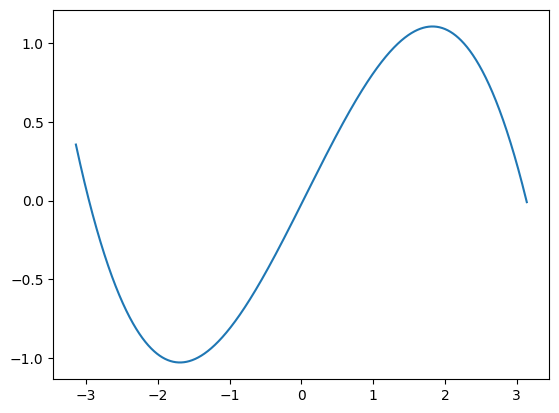

In [ ]:
plt.plot(xx, [y.data for y in list(map(pseudo_sin, xx))])

#Построение MLP модели на основе класса Value

In [ ]:
import random
from typing import List


class Module:
    def zero_grad(self) -> None:
        for p in self.parameters():
          p.grad = 0

    def parameters(self) -> List[Value]:
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w: List[Value] = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b: Value = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((self.w[i] * x[i] for i in range(len(self.w))), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self) -> List[Value]:
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz =
        self.layers = [Layer(sz[i], sz[i+1], nonlin=(i!=len(nouts)-1)) for i in range(len(nouts))]

    def __call__(self, x):
        ...
        return x

    def parameters(self):
        return ...

    def __repr__(self):
        repr = '\n'.join(str(layer) for layer in self.layers)
        return f"MLP of [{repr}]"

# Визуализация обучения

https://docs.wandb.ai/guides/integrations/pytorch

https://docs.wandb.ai/ref/python/watch  

https://docs.wandb.ai/guides/track/jupyter

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
import wandb
run = wandb.init(project="polynom_learning_")

In [ ]:
run.finish()

# Обучение собственной модели MLP

In [ ]:
np.random.seed(1337)
random.seed(1337)

In [ ]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)]
Layer of [LinearNeuron(16)]]
number of parameters 337


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

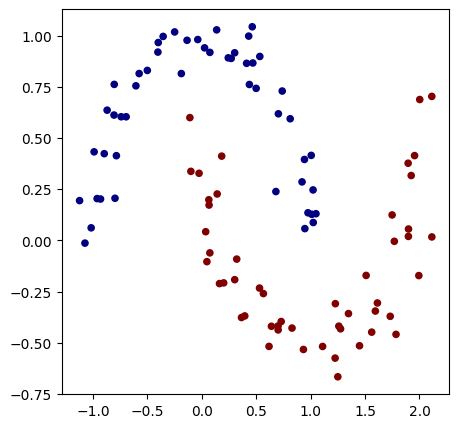

In [ ]:
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1) # [n x 2], [n,]
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [ ]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = ...

    # svm "max-margin" loss
    # https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote09.html
    # https://en.wikipedia.org/wiki/Hinge_loss
    losses = ...
    data_loss = sum(losses)/len(losses)
    # L2 regularization
    alpha = 1e-4
    reg_loss = ...

    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

TypeError: ignored

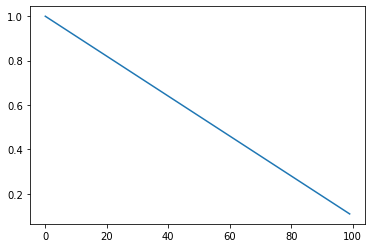

In [ ]:
#draw learning rate
learning_rate = lambda k: 1.0 - 0.9*k/100
x = list(range(100))
plt.plot(x, list(map(learning_rate, x)))

In [ ]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    learning_rate = ...
    # backward (zero_grad + backward)
    ...
    # update (sgd)
    for p in model.parameters():
      ...

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 34 loss 0.01917769152367769, accuracy 100.0%
step 35 loss 0.019684119623731382, accuracy 100.0%
step 36 loss 0.021326141038309505, accuracy 100.0%


KeyboardInterrupt: ignored

(-1.60880919956848, 1.89119080043152)

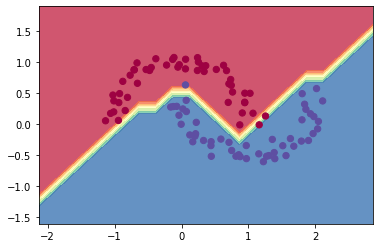

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())